In [32]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Dropout,
    BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import cv2
import matplotlib.pyplot as plt
import seaborn as sns



In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    zoom_range=0.05,
    horizontal_flip=False,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/CV/Brain Tumor Detection Dataset/advanced_brain_tumor_dataset/Training',
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle = True
)

val_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/CV/Brain Tumor Detection Dataset/advanced_brain_tumor_dataset/Training',
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle = False,
    classes=list(train_generator.class_indices.keys()) #enforces same indices as train
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [8]:
base_model = EfficientNetB1(
    include_top=False,
    weights="imagenet",
    input_shape=(240, 240, 3),
)

base_model.name = "EfficientNetB1"
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation="softmax")(x)

model = Model(base_model.input, outputs)

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [10]:
print(train_generator.class_indices)
print(val_generator.class_indices)


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [11]:
#finding class weights
y_train = train_generator.classes

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(1.0811258278145695), 1: np.float64(1.0659981343283582), 2: np.float64(0.8955721003134797), 3: np.float64(0.9800600343053173)}


In [12]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weights,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.5314 - loss: 1.0592 - val_accuracy: 0.7082 - val_loss: 0.7704
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 96s 669ms/step - accuracy: 0.8280 - loss: 0.4895 - val_accuracy: 0.7528 - val_loss: 0.6366
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 97s 676ms/step - accuracy: 0.8668 - loss: 0.3894 - val_accuracy: 0.7730 - val_loss: 0.5524
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 98s 689ms/step - accuracy: 0.8792 - loss: 0.3605 - val_accuracy: 0.7721 - val_loss: 0.5445
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 96s 672ms/step - accuracy: 0.8819 - loss: 0.3240 - val_accuracy: 0.8081 - val_loss: 0.4785
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 95s 664ms/step - accuracy: 0.8921 - loss: 0.3077 - val_accuracy: 0.8037 - val_loss: 0.4692
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 95s 668ms/step - accuracy: 0.9020 - loss: 0.2923 - val_accuracy: 0.8335 - val_loss: 0.4415
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 95s 663ms/step - accuracy: 0.9035 - loss: 0.2

In [13]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, type(layer))


0 input_layer_1 <class 'keras.src.layers.core.input_layer.InputLayer'>
1 rescaling_2 <class 'keras.src.layers.preprocessing.rescaling.Rescaling'>
2 normalization_1 <class 'keras.src.layers.preprocessing.normalization.Normalization'>
3 rescaling_3 <class 'keras.src.layers.preprocessing.rescaling.Rescaling'>
4 stem_conv_pad <class 'keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D'>
5 stem_conv <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
6 stem_bn <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
7 stem_activation <class 'keras.src.layers.activations.activation.Activation'>
8 block1a_dwconv <class 'keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D'>
9 block1a_bn <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
10 block1a_activation <class 'keras.src.layers.activations.activation.Activation'>
11 block1a_se_squeeze <class 'keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D'>
12

In [15]:
#Fine Tuning
#unfreezing part of backbone

TOTAL_LAYERS = len(model.layers)

efficientnet_start = 4
efficientnet_end = 339

unfreeze_from = int(
    efficientnet_start + 0.8 * (efficientnet_end - efficientnet_start)
)

for layer in model.layers[unfreeze_from:efficientnet_end]:
    layer.trainable = True

In [16]:
#recompile with lower LR
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [17]:
#re-train with lower epochs
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 179s 938ms/step - accuracy: 0.8550 - loss: 0.4511 - val_accuracy: 0.8273 - val_loss: 0.4262
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 657ms/step - accuracy: 0.9052 - loss: 0.2914 - val_accuracy: 0.8273 - val_loss: 0.4436
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 95s 663ms/step - accuracy: 0.9076 - loss: 0.2572 - val_accuracy: 0.8265 - val_loss: 0.4253
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 97s 681ms/step - accuracy: 0.9233 - loss: 0.2227 - val_accuracy: 0.8466 - val_loss: 0.3915
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 97s 682ms/step - accuracy: 0.9443 - loss: 0.1805 - val_accuracy: 0.8589 - val_loss: 0.3575
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 97s 677ms/step - accuracy: 0.9454 - loss: 0.1688 - val_accuracy: 0.8738 - val_loss: 0.3401
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 96s 672ms/step - accuracy: 0.9460 - loss: 0.1515 - val_accuracy: 0.8834 - val_loss: 0.3158
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 96s 667ms/step - accuracy: 0.9477 - loss: 

In [25]:
#test, accuracy, save
test_datagen = ImageDataGenerator(preprocess_input)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/CV/Brain Tumor Detection Dataset/advanced_brain_tumor_dataset/Testing',
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    classes=list(train_generator.class_indices.keys())
)

Found 1311 images belonging to 4 classes.


In [26]:
print(train_generator.class_indices)
print(test_generator.class_indices)


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [27]:
scores = model.evaluate(test_generator)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

model.save("Advanced_Brain_Tumor_Detection_Model.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 526ms/step - accuracy: 0.8954 - loss: 0.2504
Test loss: 0.1965498924255371
Test accuracy: 0.9214340448379517


In [28]:
#confusion matrix

test_generator.reset()

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())


41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 414ms/step


In [29]:
class_names = list(test_generator.class_indices.keys())
print(class_names)


['glioma', 'meningioma', 'notumor', 'pituitary']


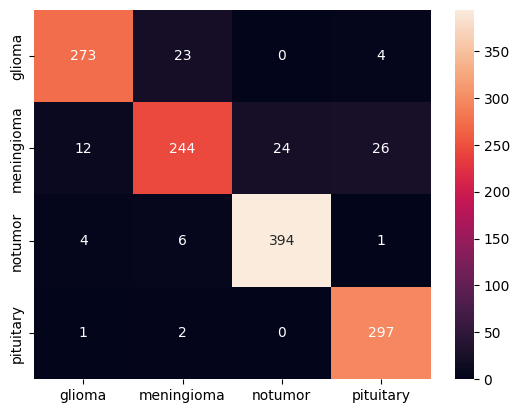

In [30]:
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.show()
